In [1]:
import matplotlib.pyplot as plt
import numpy as np

import jax
import jax.numpy as jnp
from jax import random
import numpy as np

# diffusionlab imports (adjust imports if your environment differs)
from diffusionlab.dynamics import VariancePreservingProcess
from diffusionlab.losses import DiffusionLoss
from diffusionlab.vector_fields import VectorFieldType

# repo imports
from src.diffusion_mem_gen.models.gmm import (
    IsoHomGMMInitStrategy,
    iso_hom_gmm_create_initialization_parameters,
    IsoHomGMMSharedParametersEstimator,
)
from src.diffusion_mem_gen.utils.factories import compute_loss_factory

key = random.PRNGKey(0)

In [2]:
# Diffusion process
diffusion_process = VariancePreservingProcess()

# Loss object: replace with your custom loss instance if you have one
loss_obj = DiffusionLoss(diffusion_process, vector_field_type=VectorFieldType.EPS, num_noise_draws_per_sample=100)

## Crafting model environment

In [3]:
# Dimension and training samples
laboratory_d = 32*32  # data dimension
laboratory_N = 300  # number of training samples
laboratory_K = 40 # number of components in the GMM
laboratory_M = 240

u_means_variance = 0.06 ** (1/2)  # order 1, controls the variance of the means of the true distribution
sample_variance = 0.06  # isotropic variance for each component


# Time grid for evaluation
times = jnp.linspace(0.01, 0.99, 26)

In [4]:
# Ground-truth GMM params (you can replace these with your exact true mixture)
key, sk = random.split(key)
true_means = random.normal(sk, (laboratory_K, laboratory_d)) * u_means_variance
equal_weighted_prior = jnp.array([1/laboratory_K for _ in range(laboratory_K)])  # must sum to 1

# Sample training set from the true GMM
key, sk = random.split(key)
comp_ids = random.choice(sk, laboratory_K, shape=(laboratory_N,), p=equal_weighted_prior)
key, sk = random.split(key)
X_train = true_means[comp_ids] + jnp.sqrt(sample_variance) * random.normal(sk, (laboratory_N, laboratory_d))

## Plotting the training points

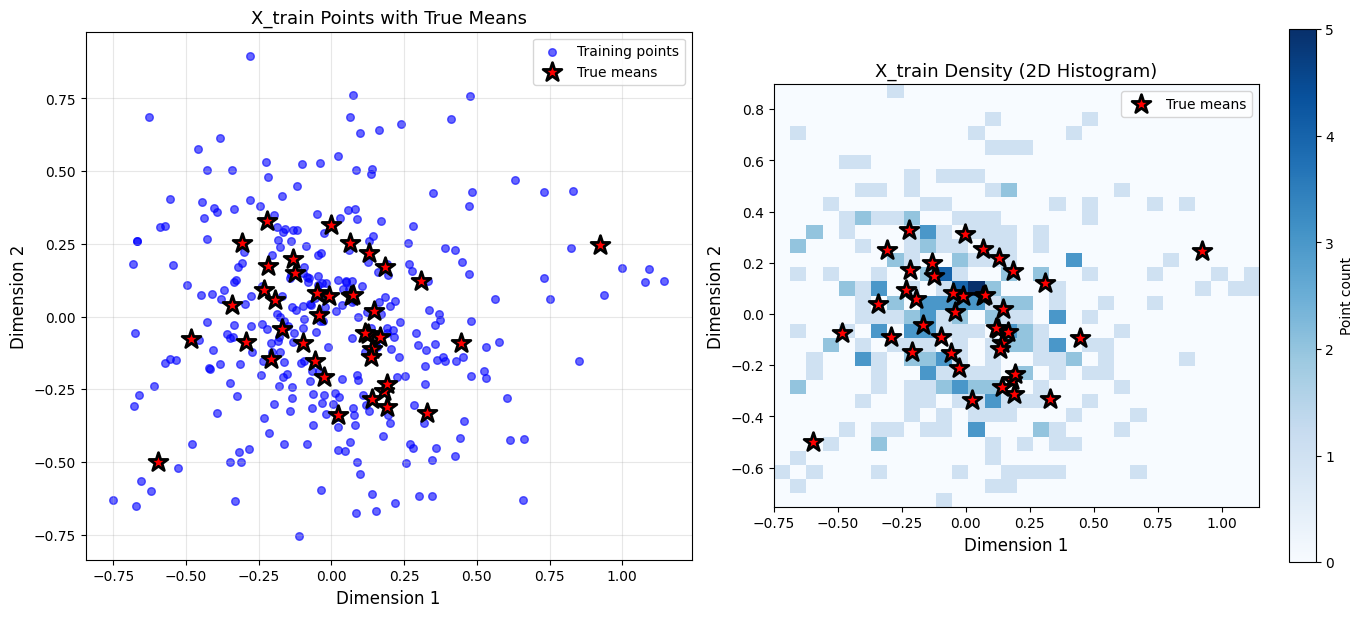

X_train shape: (300, 1024)
Number of training points: 300
True means:
[[-0.59827703 -0.49863786  0.05034785 ...  0.3292691   0.6060165
   0.36123767]
 [ 0.16536127 -0.07196518 -0.11442596 ... -0.08251666 -0.1713818
  -0.00186981]
 [ 0.44603097 -0.09197649  0.06492318 ... -0.0283416   0.22313267
   0.19499736]
 ...
 [-0.04991079  0.08077235 -0.02366443 ... -0.4121712  -0.25944203
  -0.01877564]
 [ 0.13424043 -0.13758573  0.01517252 ... -0.1851489   0.3698451
   0.20760377]
 [-0.13311593  0.19862948  0.06514981 ... -0.02130336  0.18704359
   0.1386263 ]]


In [5]:
# Plot X_train points to visualize their density
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Convert to numpy for plotting
X_train_np = np.array(X_train)
true_means_np = np.array(true_means)

# Left plot: Scatter plot with true means
ax1 = axes[0]
ax1.scatter(X_train_np[:, 0], X_train_np[:, 1], alpha=0.6, s=30, c='blue', label='Training points')
ax1.scatter(true_means_np[:, 0], true_means_np[:, 1], s=200, c='red', marker='*', 
           edgecolors='black', linewidths=2, label='True means', zorder=5)
ax1.set_xlabel('Dimension 1', fontsize=12)
ax1.set_ylabel('Dimension 2', fontsize=12)
ax1.set_title('X_train Points with True Means', fontsize=13)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_aspect('equal', adjustable='box')

# Right plot: 2D histogram showing density
ax2 = axes[1]
# Create a 2D histogram
H, xedges, yedges = np.histogram2d(X_train_np[:, 0], X_train_np[:, 1], bins=30)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
im = ax2.imshow(H.T, origin='lower', extent=extent, cmap='Blues', aspect='auto', interpolation='nearest')
ax2.scatter(true_means_np[:, 0], true_means_np[:, 1], s=200, c='red', marker='*', 
           edgecolors='black', linewidths=2, label='True means', zorder=5)
ax2.set_xlabel('Dimension 1', fontsize=12)
ax2.set_ylabel('Dimension 2', fontsize=12)
ax2.set_title('X_train Density (2D Histogram)', fontsize=13)
ax2.legend(fontsize=10)
plt.colorbar(im, ax=ax2, label='Point count')
ax2.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

print(f"X_train shape: {X_train.shape}")
print(f"Number of training points: {laboratory_N}")
print(f"True means:\n{true_means_np}")

### Investigating how the points evolve with the forward process

In [6]:
t_n_value = jnp.array(0.5)

In [7]:
key, subk = random.split(key)
X_t_n_eps = jax.random.normal(subk, X_train.shape)

batch_diffusion_forward = jax.vmap(
            diffusion_process.forward, in_axes=(0, None, 0)
        )
X_t_n_dataset = batch_diffusion_forward(X_train, t_n_value, X_t_n_eps)

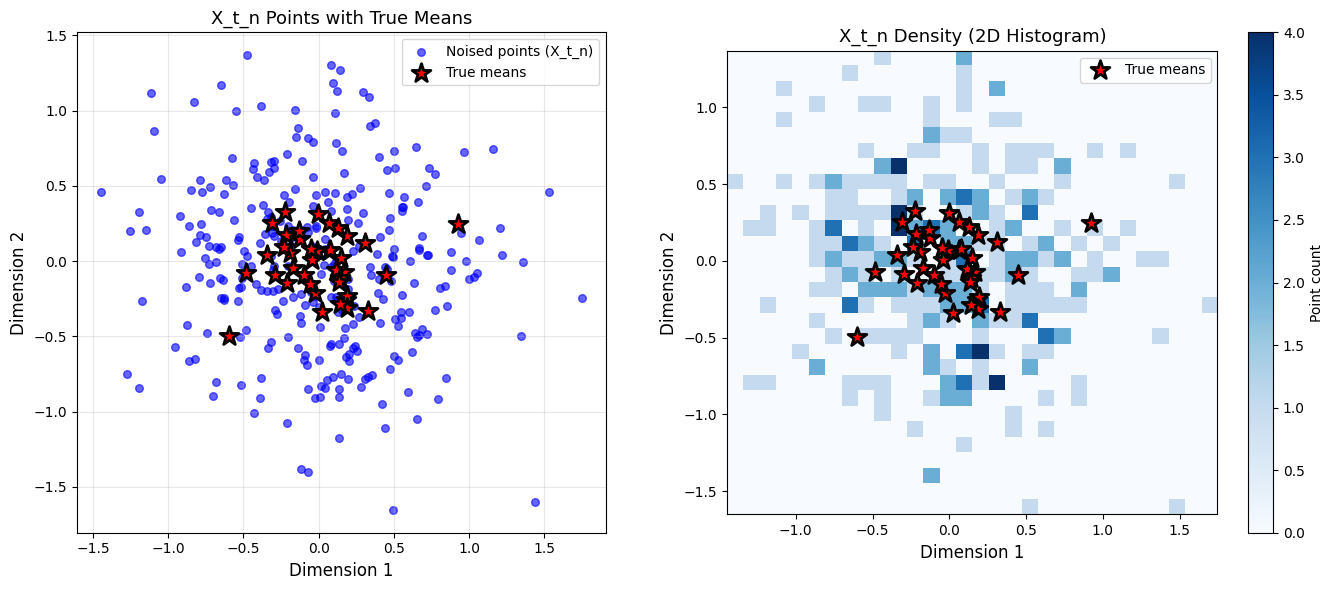

X_t_n_dataset shape: (300, 1024)
Number of training points: 300
True means:
[[-0.59827703 -0.49863786  0.05034785 ...  0.3292691   0.6060165
   0.36123767]
 [ 0.16536127 -0.07196518 -0.11442596 ... -0.08251666 -0.1713818
  -0.00186981]
 [ 0.44603097 -0.09197649  0.06492318 ... -0.0283416   0.22313267
   0.19499736]
 ...
 [-0.04991079  0.08077235 -0.02366443 ... -0.4121712  -0.25944203
  -0.01877564]
 [ 0.13424043 -0.13758573  0.01517252 ... -0.1851489   0.3698451
   0.20760377]
 [-0.13311593  0.19862948  0.06514981 ... -0.02130336  0.18704359
   0.1386263 ]]


In [8]:
# Plot X_t_n_dataset points to visualize their density
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Convert to numpy for plotting
X_t_n_np = np.array(X_t_n_dataset)
true_means_np = np.array(true_means)

# Left plot: Scatter plot with true means
ax1 = axes[0]
ax1.scatter(X_t_n_np[:, 0], X_t_n_np[:, 1], alpha=0.6, s=30, c='blue', label='Noised points (X_t_n)')
ax1.scatter(true_means_np[:, 0], true_means_np[:, 1], s=200, c='red', marker='*', 
           edgecolors='black', linewidths=2, label='True means', zorder=5)
ax1.set_xlabel('Dimension 1', fontsize=12)
ax1.set_ylabel('Dimension 2', fontsize=12)
ax1.set_title('X_t_n Points with True Means', fontsize=13)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_aspect('equal', adjustable='box')

# Right plot: 2D histogram showing density
ax2 = axes[1]
# Create a 2D histogram
H, xedges, yedges = np.histogram2d(X_t_n_np[:, 0], X_t_n_np[:, 1], bins=30)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
im = ax2.imshow(H.T, origin='lower', extent=extent, cmap='Blues', aspect='auto', interpolation='nearest')
ax2.scatter(true_means_np[:, 0], true_means_np[:, 1], s=200, c='red', marker='*', 
           edgecolors='black', linewidths=2, label='True means', zorder=5)
ax2.set_xlabel('Dimension 1', fontsize=12)
ax2.set_ylabel('Dimension 2', fontsize=12)
ax2.set_title('X_t_n Density (2D Histogram)', fontsize=13)
ax2.legend(fontsize=10)
plt.colorbar(im, ax=ax2, label='Point count')
ax2.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

print(f"X_t_n_dataset shape: {X_t_n_dataset.shape}")
print(f"Number of training points: {laboratory_N}")
print(f"True means:\n{true_means_np}")

### Checking that the requirements of the model hold

In [18]:
# Check that the min distance between the means is order d, and the max modulus is order d.

from scipy.spatial.distance import pdist
import numpy as np

# Calculate all pairwise distances between the means
pairwise_dists = pdist(true_means)
min_dist = np.min(pairwise_dists)

# Calculate the maximum modulus (maximum Euclidean norm from origin)
max_modulus = np.max(np.linalg.norm(true_means, axis=1))

print(f"Minimum distance between means: {min_dist:.3f} (should be ~O(d) == {laboratory_d})")
print(f"Maximum modulus of any mean: {max_modulus:.3f} (should be ~O(d) == {laboratory_d})")

Minimum distance between means: 10.188 (should be ~O(d) == 1024)
Maximum modulus of any mean: 8.287 (should be ~O(d) == 1024)


### Defining the Diffusion Process, and the diffusin loss_obj  

### Build PMEM denoiser (uses training points as memorised means)

In [9]:
key, sk = random.split(key)

context = {
    "X_train": X_train,
    "init_var_scale": 1e-10,
    "init_means_noise_var": 0.0, # Not exactly sure what this is
}
means_pmem, var_pmem, priors_pmem = iso_hom_gmm_create_initialization_parameters(
    sk, IsoHomGMMInitStrategy.PMEM, laboratory_d, laboratory_M, context
)

pmem_model = IsoHomGMMSharedParametersEstimator(
    dim=laboratory_d,
    num_components=laboratory_M,
    vf_type=VectorFieldType.X0,
    diffusion_process=diffusion_process,
    init_means=means_pmem,
    init_var=var_pmem,
    priors=priors_pmem,
)

C:\Users\chris\AppData\Local\Temp\ipykernel_24900\2745336814.py:12: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  pmem_model = IsoHomGMMSharedParametersEstimator(


### Build MEM denoiser (uses training points as memorised means)


In [10]:
key, sk = random.split(key)

means_mem, var_mem, priors_mem = iso_hom_gmm_create_initialization_parameters(
    sk, IsoHomGMMInitStrategy.PMEM, laboratory_d, laboratory_N, context
)

mem_model = IsoHomGMMSharedParametersEstimator(
    dim=laboratory_d,
    num_components=laboratory_N,
    vf_type=VectorFieldType.X0,
    diffusion_process=diffusion_process,
    init_means=means_mem,
    init_var=var_mem,
    priors=priors_mem,
)

C:\Users\chris\AppData\Local\Temp\ipykernel_24900\4216725792.py:7: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  mem_model = IsoHomGMMSharedParametersEstimator(


### Build Generalising denoiser

In [11]:
generalising_model = IsoHomGMMSharedParametersEstimator(
    dim=laboratory_d,
    num_components=laboratory_K,
    vf_type=VectorFieldType.X0,
    diffusion_process=diffusion_process,
    init_means=true_means,
    init_var=jnp.asarray(sample_variance),
    priors=equal_weighted_prior,
)

C:\Users\chris\AppData\Local\Temp\ipykernel_24900\2340100790.py:1: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  generalising_model = IsoHomGMMSharedParametersEstimator(


In [12]:
from investigating_diffusion_loss import AmbientDiffusionLoss

t_n_value = jnp.array(0.1)
t_val = jnp.array(0.15)

In [13]:
ambient_loss_obj = AmbientDiffusionLoss(diffusion_process, num_noise_draws_per_sample=1, t_n=t_n_value)

## Writing the Loss Objective

In [15]:
def L_N(key, model_callable, lambda_fn, t_val_array, t_n_value, X_0_dataset, X_t_n_dataset):
    '''
    This function computes the L_N loss for a given model and a given lambda function.
    '''

    ambient_loss_obj = AmbientDiffusionLoss(diffusion_process, num_noise_draws_per_sample=1, t_n=t_n_value)
    standard_loss_obj = DiffusionLoss(diffusion_process, vector_field_type=VectorFieldType.X0, num_noise_draws_per_sample=1)

    def L_N_t_ambient(key, model_callable, t_n_value, t_val, X_t_n_dataset):
        '''
        This function computes the L_N_t for the ambient denoising term.
        '''
        assert t_val > t_n_value
        
        compute_loss = compute_loss_factory(ambient_loss_obj, jnp.array(t_val))
        loss_val = compute_loss(key, model_callable, X_t_n_dataset) / X_train.shape[0] 
        
        return loss_val

    def L_N_t_standard_score(key, model_callable, t_val, X_t_dataset):
        '''
        This function computes the L_N_t for the standard denoising term.
        '''
        compute_loss = compute_loss_factory(standard_loss_obj, jnp.array(t_val))
        loss_val = compute_loss(key, model_callable, X_t_dataset) / X_train.shape[0] 
        
        return loss_val
    
    # Split into less than t_n and greater than t_n
    less_than_n_mask = jnp.less_equal(t_val_array, t_n_value)
    greater_than_n_mask = jnp.logical_not(less_than_n_mask)

    standard_denoising_t_values = t_val_array[less_than_n_mask]
    ambient_denoising_t_values = t_val_array[greater_than_n_mask]
  
    # Compute the loss for the standard denoising term
    standard_denoising_loss_values = []
    for t in standard_denoising_t_values:
        key, subk = random.split(key)
        loss_val = L_N_t_standard_score(subk, model_callable, t, X_0_dataset)
        standard_denoising_loss_values.append(lambda_fn(t) * loss_val)

    averaged_standard_denoising_loss = np.mean(standard_denoising_loss_values)

    # Compute the loss for the ambient denoising term
    ambient_denoising_loss_values = []
    for t in ambient_denoising_t_values:
        key, subk = random.split(key)
        loss_val = L_N_t_ambient(key, model_callable, t_n_value, t, X_t_n_dataset)
        ambient_denoising_loss_values.append(lambda_fn(t) * loss_val)
    
    averaged_ambient_denoising_loss = np.mean(ambient_denoising_loss_values)

    return averaged_standard_denoising_loss + averaged_ambient_denoising_loss, standard_denoising_loss_values, ambient_denoising_loss_values


In [16]:
lambda_fn = lambda t: 1
    

t_val_array = jnp.linspace(0.01, 0.99, 26)
t_n_value = jnp.array(0.5)

key, subk = random.split(key)
X_t_n_eps = jax.random.normal(subk, X_train.shape)

batch_diffusion_forward = jax.vmap(
            diffusion_process.forward, in_axes=(0, None, 0)
        )
X_t_n_dataset = batch_diffusion_forward(X_train, t_n_value, X_t_n_eps)

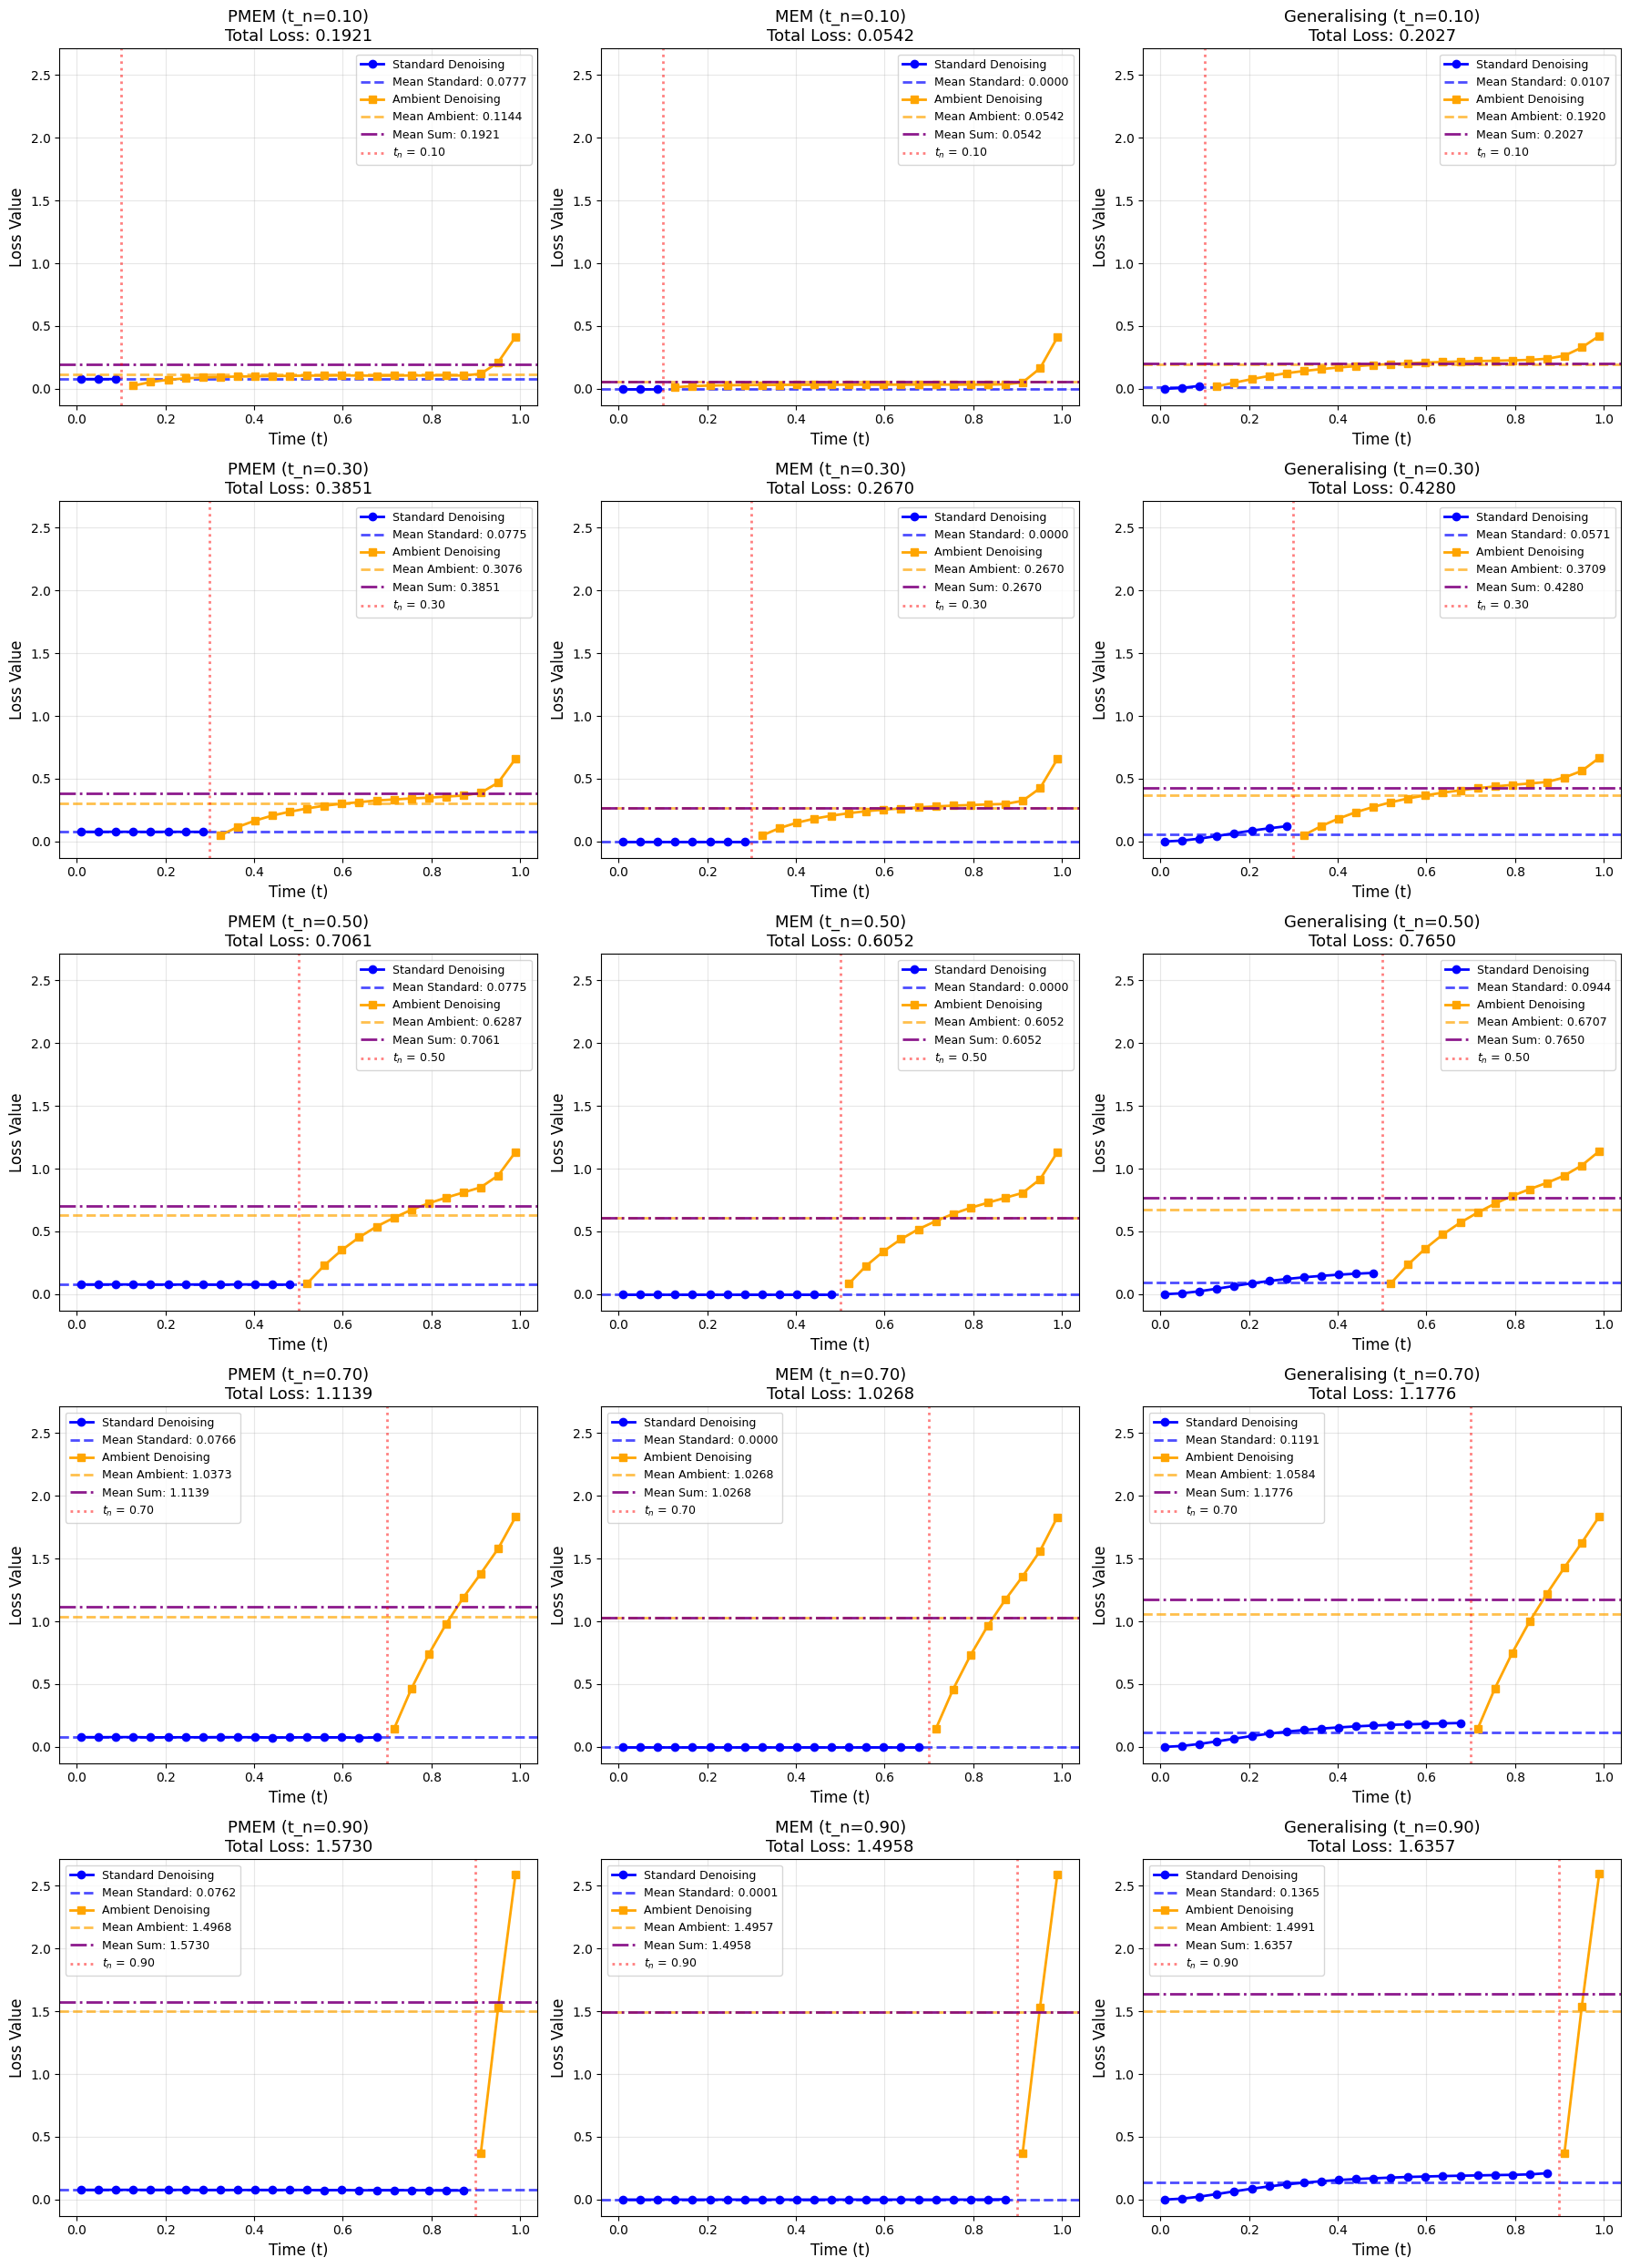

In [17]:
# For each t_n_value in the array, generate the plot as before
t_n_values = np.linspace(0.1, 0.9, 5)  # 5 values between 0 and 0.9

t_val_array = jnp.linspace(0.01, 0.99, 26)

models = ['PMEM', 'MEM', 'Generalising']
model_objs = [pmem_model, mem_model, generalising_model]

# We'll plot each t_n_value in a row; 
# Each row will have 3 columns (one per model), for a grid of len(t_n_values) x 3.

# ----------- Determine global y-limits for all losses -----------
all_losses = []

for t_n_value in t_n_values:
    t_n_value_jax = jnp.array(t_n_value)
    key, subk = random.split(key)
    X_t_n_eps = jax.random.normal(subk, X_train.shape)
    batch_diffusion_forward = jax.vmap(
            diffusion_process.forward, in_axes=(0, None, 0)
        )
    
    key, subk = random.split(key)
    X_t_n_dataset = batch_diffusion_forward(X_train, t_n_value_jax, X_t_n_eps)
    results = [
        L_N(subk, model_obj, lambda_fn, t_val_array, t_n_value_jax, X_train, X_t_n_dataset)
        for model_obj in model_objs
    ]
    for result in results:
        _, standard_denoising_loss_values, ambient_denoising_loss_values = result
        all_losses.extend(np.array(standard_denoising_loss_values).flatten())
        all_losses.extend(np.array(ambient_denoising_loss_values).flatten())

# Compute global min and max for y-axis, with some padding
all_losses = np.array(all_losses)
ymin = np.min(all_losses)
ymax = np.max(all_losses)
ypad = 0.05 * (ymax - ymin) if ymax > ymin else 1.0
ymin = ymin - ypad
ymax = ymax + ypad

# -------------- Now do the main plotting --------------
fig, axes = plt.subplots(len(t_n_values), 3, figsize=(18, 5 * len(t_n_values)), squeeze=False)  

for row_idx, t_n_value in enumerate(t_n_values):
    t_n_value_jax = jnp.array(t_n_value)
    key, subk = random.split(key)
    X_t_n_eps = jax.random.normal(subk, X_train.shape)
    batch_diffusion_forward = jax.vmap(
            diffusion_process.forward, in_axes=(0, None, 0)
        )
    X_t_n_dataset = batch_diffusion_forward(X_train, t_n_value_jax, X_t_n_eps)
    key, subk = random.split(key)
    results = [
        L_N(key, model_obj, lambda_fn, t_val_array, t_n_value_jax, X_train, X_t_n_dataset)
        for model_obj in model_objs
    ]
    for col_idx, (ax, model_name, result) in enumerate(zip(axes[row_idx], models, results)):
        total_loss, standard_denoising_loss_values, ambient_denoising_loss_values = result
        
        # Get the t values for each section
        less_than_n_mask = jnp.less_equal(t_val_array, t_n_value)
        standard_denoising_t_values = t_val_array[less_than_n_mask]
        ambient_denoising_t_values = t_val_array[jnp.logical_not(less_than_n_mask)]
        
        # Convert to numpy for plotting
        standard_t_np = np.array(standard_denoising_t_values)
        ambient_t_np = np.array(ambient_denoising_t_values)
        standard_loss_np = np.array(standard_denoising_loss_values)
        ambient_loss_np = np.array(ambient_denoising_loss_values)
        
        # Calculate means
        mean_standard = np.mean(standard_loss_np)
        mean_ambient = np.mean(ambient_loss_np)
        mean_sum = mean_standard + mean_ambient  # Add the requested line: the averages summed
        
        # Plot standard denoising losses
        if len(standard_t_np) > 0:
            ax.plot(standard_t_np, standard_loss_np, 'o-', label='Standard Denoising', 
                    linewidth=2, markersize=6, color='blue')
            ax.axhline(y=mean_standard, color='blue', linestyle='--', 
                      linewidth=2, alpha=0.7, label=f'Mean Standard: {mean_standard:.4f}')
        
        # Plot ambient denoising losses
        if len(ambient_t_np) > 0:
            ax.plot(ambient_t_np, ambient_loss_np, 's-', label='Ambient Denoising', 
                    linewidth=2, markersize=6, color='orange')
            ax.axhline(y=mean_ambient, color='orange', linestyle='--', 
                      linewidth=2, alpha=0.7, label=f'Mean Ambient: {mean_ambient:.4f}')
        
        # Plot horizontal line for the sum of means
        ax.axhline(y=mean_sum, color='purple', linestyle='-.', linewidth=2, alpha=0.9, label=f"Mean Sum: {mean_sum:.4f}")

        # Add vertical line at t_n
        ax.axvline(x=float(t_n_value), color='red', linestyle=':', 
                  linewidth=2, alpha=0.5, label=f'$t_n$ = {float(t_n_value):.2f}')
        
        ax.set_xlabel('Time (t)', fontsize=12)
        ax.set_ylabel('Loss Value', fontsize=12)
        ax.set_title(f'{model_name} (t_n={float(t_n_value):.2f})\nTotal Loss: {float(total_loss):.4f}', fontsize=13)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=9)
        
        # Set the global y-limits for this row
        ax.set_ylim([ymin, ymax])

plt.tight_layout()
plt.show()